## Import required python libraries

In [1]:
import tables
from google.cloud import bigquery
from datetime import datetime, timedelta
import time
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import os.path
pd.options.display.max_colwidth = 500
import collections
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis.sklearn
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.gensim  
from pprint import pprint
import gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


/opt/conda/lib/python3.7/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/opt/conda/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Read from bigquery

In [2]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))
# read data
query = """
    select * FROM `LSA_2020_granularity_of_day.speech_to_text`  
"""
raw_data = pd.read_gbq(query, dialect='standard')
raw_data.shape

Client creating using default project: gaf-np-ds


Downloading: 100%|██████████| 5498/5498 [00:02<00:00, 2055.01rows/s]


(5498, 11)

In [400]:
# textdata=raw_data[raw_data.user_location.str.contains('|'.join(usa_locations),na=False)]
# textdatanull=raw_data[raw_data['user_location'].isna()]
# textdata=pd.concat([textdata,textdatanull])
textdata=raw_data.copy()
textdata['text']=textdata['Transcript']
print(textdata.shape)

(5498, 12)


## Cleanning text data before getting insights

In [ ]:
# Display one duplicate
# print(textdata.sort_values('text')['text'][:5])  # some instances of duplicate
# print('no of unique sentences',len(textdata['text'].unique()))
raw_data['Transcript'].sample(1).iloc[0]

#### Remove duplicate text, convert to lowercase

In [540]:
# Drop duplicate
# textdata=textdata.copy()

textdata=textdata.drop_duplicates(subset={'text'})
print(textdata.shape)

#convert to lower
textdata['text']=textdata['text'].apply(lambda x: x.lower()).copy()

l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words',len(set([item for sublist in l for item in sublist])))

(4808, 15)
No of unique words 9390


In [404]:
#remove transcript
textdata['text']=textdata['text'].apply(lambda x : x.replace('transcript:',''))


l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words before stem',len(set([item for sublist in l for item in sublist])))

#convert \n to .
textdata['text']=textdata['text'].apply(lambda x : x.replace('\n','.'))
textdata['text']=textdata['text'].apply(lambda x : x.replace('?','.'))
textdata['text']=textdata['text'].apply(lambda x : x.replace('?','.'))

#remove some sentence where specific keyword is there which are not useful
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'good afternoon' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'good morning' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'for calling' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'monitored or recorded' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'My name is' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'press' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'training purpose' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'this is' not in i))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('.') if 'missed your call' not in i))


#make shorter sentences
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('if')))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('but')))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('and')))
textdata['text']=textdata['text'].apply(lambda x : '.'.join(i for i in x.split('because')))



textdata['text'].sample(1)                                        


No of unique words before stem 45301


3683     hey you calling barnett roofing. how may i help you..  your own . i need you to fix that. so that's possible..  okay, so you said you have a leaky roof..  i didn't have use the birth stone..  two...
Name: text, dtype: object

In [405]:
textdata1=textdata.copy()
raw_data['Transcript'].loc[2267]
# stop

"Transcript: Free operations manager for Midsouth construction. I'm sorry that I missed your call. But if you leave your\n"

In [406]:
#take only important sentences
totake=['claim','warranty','gurantee','insurance','quote','roof','company','estimate'  \
        'appointment','schedule','inspect',  \
        'shingles','gutter','asphalt', \
        'damage','leak','broke','crack', \
        'weather','storm','rain','tornedo','hail','hurricane','wind']
textdata['text']=textdata['text'].apply(lambda x : '.'.join([i for i in x.split('.') if any(word in i for word in totake)]))




In [408]:
# set(stopwords.words('english'))
textdata['text'].loc[100]

" there's a little strip of siding that came loose as a result of the strong winds couple of weeks ago . do you know kevin you while idea how much should we do cost to do something like that since it's relatively not state super steep roof or anything of hard to get up "

In [409]:
textdata['text'][0]

def cleanpunc(sentence):
    cleaned=re.sub(r'[-|\|(|)|,|:|,|/|?|!|"|#]',r' ',sentence)
    return cleaned

# textdata['text']=textdata['text'].apply(cleanpunc)



In [410]:
raw_data['Transcript'].loc[556]

"Transcript: Thank you for calling roofie. Bye Curry. Why worry call Curry if you know your party's extension, you may dial it at any time.\nTranscript:  for general assistance, press 1\nTranscript:  to schedule an estimate, press 2.\nTranscript:  Good morning. Thank you for calling bye Curry. This is Charlie. How can else you yes, hi, by any chance, you do free quotes in lawn poke have a villa on the Gulf of Mexico Drive and there's a leak and the AC guy went up on top of the roof and showed us where she thinks it's leaking into my bathroom ceiling and he took pictures. So I wanted to know if I can send it to your roof guy and you can look at it and maybe give me an estimate like if that's something he can do.\nTranscript:  106 twin Shores Boulevard\nTranscript:  Do you go to Longboat Key?\nTranscript:  Main Street Garage\nTranscript:  1 Shores Boulevard defense\nTranscript:  Twin Shores Boulevard. Now when you GPS it takes you his main street and that's not correct. So you got a real

In [411]:
textdata['text'].loc[556]  
textdata['text'].sample(50)

1447     i could get an estimate on gutters my home. so the next step is one of my consult when i contact you today to schedule best time . okay, sunday, okay, so i cannot roofing contact going to contact...
727      i'd like to get a quote possible. i need i need to be roof of my house.  yeah, we're get some counseling on what what what what's the best way or reroof adore. let him know that you need some inf...
2538      okay, this company man is roofing in construction. did you request any roofing or construction work or.  yes about my car the warranty my car. i don't have too much time for the company.  superi...
2634     you could give me an estimate of how much your average roof inspection cost. the roof inspection is $200 that entails a full inspection from our service department. then it does get typed up on o...
3517                                                                                                                                   broadstone having a gutter instal

## Remove stopwords different columns

In [414]:
#
mystopwords=set({'welcome','ahead','sounds','bit','couple','welcome','text','lets','hear','working','still','speak','came','talk','whatever','yep','least',
                 'still','roof','roofing','trying','looking','guess','called','coming','even','best','thanks','reached','regarding',
                 'press','dial','extension','hold','guys','little','around','tell','com','great','recording','telephone',
                 'forward','comes','clearly','perfect','reach','tracy','property','idge','wanted','sharon','available',
                 'return','missed','word','katie','home','house','wondering','people','fine','said','shannon','correct',
                 'got','already','help','greg','lewisville','going','morton','speaking','phone','number','call','calling',
                 'leave','name','shanon','brenda','monitored','recorded','done','transcript','dont','thats','well','want',
                 'cuz','theres','take','ill','could','would','youre','please','may','yes','whats','th','ohh','fuck',
                     'whole', 'probably','kind', 'let','sorry','something', 'put','sir','hey','ive','sure', 'able','didnt','might','also',
                     'mean', 'really', 'actually','much','someone','soon','possible','maybe', 'chris', 'provide', 'youve','pm',
                     'david','set','full','windows', 'john','im','carolina','us','hi','hes', 'theyre', 'thing', 'way', 'gmailcom',
                     'sure', 'everything', 'make', 'say', 'lot', 'think','somebody','find','think','cant','shortly', 'mary', 'florida','id','oh',
                     'two','single','moment','person','robert','ohio', 'king','san','cheryl','sam','texas','ken','rd','frank','mike','michael',
                     'jeff','lisa','mr','jessica','thomas','jordan','virginia',
                     'hello','thank','okay','know','go','like','yeah','look','come','one','alright','see','bye','need','give','good','right',
                     'back','time','guy','say','last','first','try','use','ask','do','let','next','use','jill','ms','things','kylie','get',
                     'want','maam','man','anything','hell','message','new','side','code','another','want','either','youll','record','hr','near'})

stop=set(stopwords.words('english'))
stop.update(mystopwords)
textdata['nostoptext']=textdata['text'].apply(lambda x : ' '.join([item for item in x.split() if item not in stop]))
# stop
l=textdata['nostoptext'].str.lower().str.split().tolist()
print('No of unique words',len(set([item for sublist in l for item in sublist])))

No of unique words 9054


## Consider nown and verb different columns

In [ ]:
# for ent in nlp('there was somebody that could give us an estimate cuz we want to').ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

textdata['nounverbtext']=textdata['text'].apply(lambda x : ' '.join([token.text for token in nlp(x) \
    if (((token.pos_=='VERB') & (token.dep_!='aus')) | (token.pos_=='PUNCT') |(token.pos_=='ADV') |(token.pos_=='ADJ') |  (token.pos_=='NOUN'))]))
    
    
#  (token.pos_!='AUX' & token.dep_=='ROOT' | 'PUNCT') |  token.pos_=='NOUN' |  

In [421]:
# raw_data['Transcript'].loc[4588]
textdata['nostoptext'].sample(1)
textdata[['text','nounverbtext']].sample(3)

,text,nounverbtext
1430,i need someone to gave me an appraisal on the roof,need gave appraisal roof
4965,"hi, do you do roof repairs. now we're in the full roof replacement. hi, can i just had a little damage. it's in the winds. we just need the full scale roof jobs, unless somebody's phone number...",", roof repairs . now full roof replacement . , can just little damage . winds . just need full scale roof jobs , phone number"
3127,"five squares carrigan roofing. i asked what it's for like is it just old are you haven't rain. he was up cleaning some gutters . he knows he got a load experience roof, . it was raining really ba...","squares roofing . asked just old rain . up cleaning gutters . knows got load experience roof , . raining really bad day . noticed leaks coming type fence come roof . company . give carrigan roofin..."


In [422]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [423]:
spacy.explain('expl')
textdata['text'].sample(1)

471     you'll sell the metal roofing 10. we are roofing company.ion roofing 
Name: text, dtype: object

In [424]:
textdata['text'].sample(1)
#POS tag dependency parseing
# nlp('there was somebody that could give us an estimate cuz we want to'): #we were looking in the attic we were told the roof is only couple years old.'): #' we noticed an area that there's obviously a leak . there was somebody that could give us an estimate cuz we want to'
doc="i'm looking to get an estimate for a roofing job that i noticed your name"
doc="i would like to talk about installing a new roof as there's somebody i can talk to about that. do an inspection . i will get that on the schedule for early this week. i will let them know to do t"
for token in nlp(doc):
#     if (((token.pos_=='VERB') & (token.dep_=='ROOT')) | (token.pos_=='ADJ')|(token.pos_=='PUNCT') |  (token.pos_=='NOUN')):
        print(token.text,'|', #token.lemma_,'|',   \
          type(token.pos_),token.pos_,'|',token.tag_,'|', token.dep_,'|')
          #  token.shape_,'|', token.is_alpha,'|', token.is_stop)
    
for ent in nlp('there was somebody that could give us an estimate cuz we want to').ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)
    
#  (token.pos_!='AUX' & token.dep_=='ROOT') |  token.pos_=='NOUN' |  
#ignore 'PRON','AUX','ADV','DET','ADP'
#aux,auspass,prep,det,punct    

i | <class 'str'> PRON | PRP | nsubj |
would | <class 'str'> VERB | MD | aux |
like | <class 'str'> VERB | VB | ROOT |
to | <class 'str'> PART | TO | aux |
talk | <class 'str'> VERB | VB | xcomp |
about | <class 'str'> ADP | IN | prep |
installing | <class 'str'> VERB | VBG | pcomp |
a | <class 'str'> DET | DT | det |
new | <class 'str'> ADJ | JJ | amod |
roof | <class 'str'> NOUN | NN | dobj |
as | <class 'str'> SCONJ | IN | mark |
there | <class 'str'> PRON | EX | expl |
's | <class 'str'> AUX | VBZ | advcl |
somebody | <class 'str'> PRON | NN | attr |
i | <class 'str'> PRON | PRP | nsubj |
can | <class 'str'> VERB | MD | aux |
talk | <class 'str'> VERB | VB | relcl |
to | <class 'str'> ADP | IN | prep |
about | <class 'str'> ADP | IN | prep |
that | <class 'str'> DET | DT | pobj |
. | <class 'str'> PUNCT | . | punct |
do | <class 'str'> AUX | VB | ROOT |
an | <class 'str'> DET | DT | det |
inspection | <class 'str'> NOUN | NN | dobj |
. | <class 'str'> PUNCT | . | punct |
i | <class

In [425]:
spacy.explain('ADP')

'adposition'

In [426]:
nlp = spacy.load("en_core_web_sm")
nlp('there was somebody that could give us an estimate cuz we want to').ents

#NER
doc=nlp('Apple is looking at buying U.K. startup for $1 billion')
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)


Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [427]:
def get_entities(sents):
  
  #############################################################
  a=[]
  for sent in sents.split('.'):
      ## chunk 1
      ent1 = ""
      ent2 = ""

      prv_tok_dep = ""    # dependency tag of previous token in the sentence
      prv_tok_text = ""   # previous token in the sentence

      prefix = ""
      modifier = ""
  
#       print(sent)  
      for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
          if tok.dep_ == "compound":
            prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
              prefix = prv_tok_text + " "+ tok.text

          # check: token is a modifier or not
          if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
              modifier = prv_tok_text + " "+ tok.text

          ## chunk 3
          if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

          ## chunk 4
          if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

          ## chunk 5  
          # update variables
          prv_tok_dep = tok.dep_
          prv_tok_text = tok.text
      #############################################################
      a.append([ent1.strip(), ent2.strip()])
  return a

In [428]:
# spacy.

In [429]:
get_entities("we now offer virtual appointments in order to keep you your family . be sure to ask our customer service representative when scheduling your free estimate. thank you for choosing shield roofing")
             
# for tok in nlp("yes, we have a roof leak and i need to see about someone coming out to look at it possibly."):
#     print(tok.text,'---',tok.dep_)

[['we', 'virtual  family'],
 ['', 'free customer service estimate'],
 ['', 'shield roofing']]

In [430]:
textdata['text'][0]

''

In [431]:
get_entities(textdata['text'][0])

[['', '']]

In [432]:
entity_pairs=[]
# for i in tqdm(textdata['text']):
for i in textdata['nounverbtext']:
    entity_pairs.append(get_entities(i))
entity_pairs[5:10]
# textdata['text'].iloc[:5].apply(lambda x: all_ent(x)) 

[[['', 'heavy wind gusts'],
  ['', ''],
  ['here  cos', 'just  repair'],
  ['roof', 'replaced insurance company'],
  ['', 'then  claim'],
  ['estimate', 'whole roof needs'],
  ['', 'lot call insurance'],
  ['when insurance company', 'adjuster']],
 [['window', ''],
  ['', ''],
  ['replacement window', 'foot  inches'],
  ['shattered  know', 'regular replacement windows house'],
  ['', 'already  company'],
  ['', ''],
  ['', ''],
  ['', ''],
  ['just  window', 'clean patch leak gutters'],
  ['', 'just window repair'],
  ['', 'check insurance company'],
  ['hope', 'know insurance'],
  ['', '']],
 [['', ''], ['motor roof', ''], ['', '']],
 [['', 'potential replacement insurance']],
 [['type gutter company', 'windows decks gutters'], ['', '']]]

In [433]:
entity_pairs[1:10]
textdata['nounverbtext'][1]


'estimate guttering work . , so gutter , so want new gutters commercial guy . dad one calling now gutters rental home , correct . property address rental one want gutters replaced . , received other quotes looking d.ferent . , other quote . roofing contractor'

In [434]:
doc=textdata['text'][0]
for tok in nlp(doc):
    if tok.dep_=='ROOT':
        print(tok.text,"..",tok.dep_)

In [435]:
def get_ralation(sents):
    a=[]
    for sent in sents.split('.'):
        doc=nlp(sent)
        matcher=Matcher(nlp.vocab)
        pattern=[{'DEP':'ROOT'},{'DEP':'prep','OP':"?"},{'DEP':'agent','OP':"?"},{'pos':'ADJ','OP':"?"}]
        matcher.add('match 1',None,pattern)
        matches=matcher(doc)
        k=len(matches)-1
        try:
            span=doc[matches[k][1]:matches[k][2]]
            a.append(span.text)
#             return(span.text)
        except:
            a.append('')  #return ''
    return a        

get_ralation(textdata['text'][0])
# relationes=[get_ralation(i) for i in tqdm(textdata['text'])]
relationes=[get_ralation(i) for i in textdata['nounverbtext']]
relationes[0:5]



[[''],
 ['estimate',
  'want new',
  'gutters rental',
  'want',
  'received other',
  'ferent',
  'quote',
  'contractor'],
 ['want',
  'look',
  'had',
  'want',
  'put',
  ',',
  'know',
  'window',
  'want',
  'received other',
  'got covid',
  'came'],
 [''],
 ['starting']]

In [436]:
# get_ralation('start estimate . roof repair . got gutter repair shingles . weather head boot inch . shingles . included shingles . door side know want weather head said total shingles . total weather . say shingles . painted spot hole weather head . going mow estimate basis foot . need numbers put stuff estimate . let know claim')


In [437]:
entity_pairs[1]

[['', 'guttering work'],
 ['new  gutters', ''],
 ['dad', 'rental  home'],
 ['one  gutters', ''],
 ['', 'other  quotes'],
 ['', ''],
 ['', ''],
 ['', '']]

In [438]:
len(relationes),len(entity_pairs)
relationes
textdata['text'][1]
relationes[1]

['estimate',
 'want new',
 'gutters rental',
 'want',
 'received other',
 'ferent',
 'quote',
 'contractor']

## Knowledge graph for each transcript

In [585]:
# entity_pairs[1]
# relationes[1]
# kg_df

{('dad', 'rental  home'): 'gutters rental'}


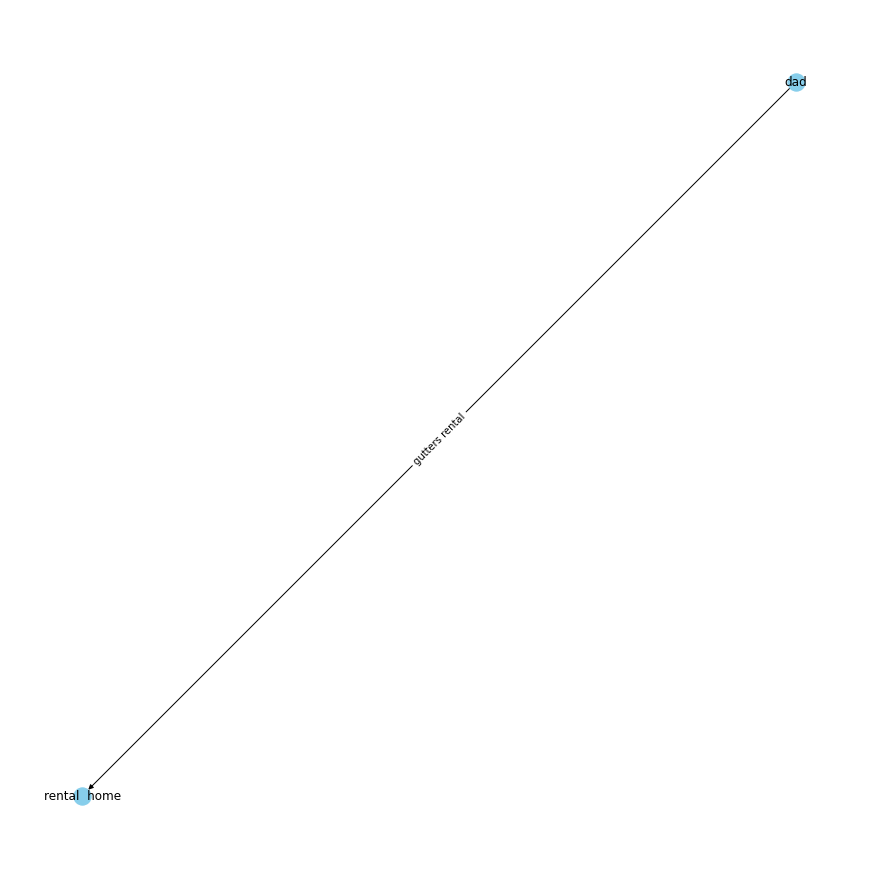

In [586]:
index=1

pd.Series(relationes).value_counts()
source=[i[0] for i in entity_pairs[index]]
target=[i[1] for i in entity_pairs[index]]
kg_df=pd.DataFrame({'source':source,'target':target,'edge':relationes[index]})
#drop duplicate and remove if any space
kg_df=kg_df.drop_duplicates()
kg_df=kg_df[(kg_df['source']>'') & (kg_df['target']>'') & (kg_df['edge']>'')]

# g=nx.from_pandas_edgelist(kg_df,"source","target",edge_attr=True,create_using=nx.MultiDiGraph())
g=nx.from_pandas_edgelist(kg_df,"source","target",edge_attr='edge',create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos=nx.spring_layout(g,k=.5)

labels = {e: g.edges[e]['edge'] for e in g.edges}
labels={(k[0],k[1]):v for  k,v in labels.items()}
print(labels)
nx.draw(g,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels)
# nx.draw(g,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)
plt.show()

In [587]:
# g=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="address to"],"source","target",edge_attr=True,create_using=nx.MultiDiGraph())
# plt.figure(figsize=(5,5))
# pos=nx.spring_layout(g,k=.5)
# nx.draw(g,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)
# plt.show()

In [588]:
# for i in range(len(entity_pairs)):
#     if len(entity_pairs[i]) !=len(relationes[i]):
#         print(i,entity_pairs[i],relationes[i])
# relationes_flatten

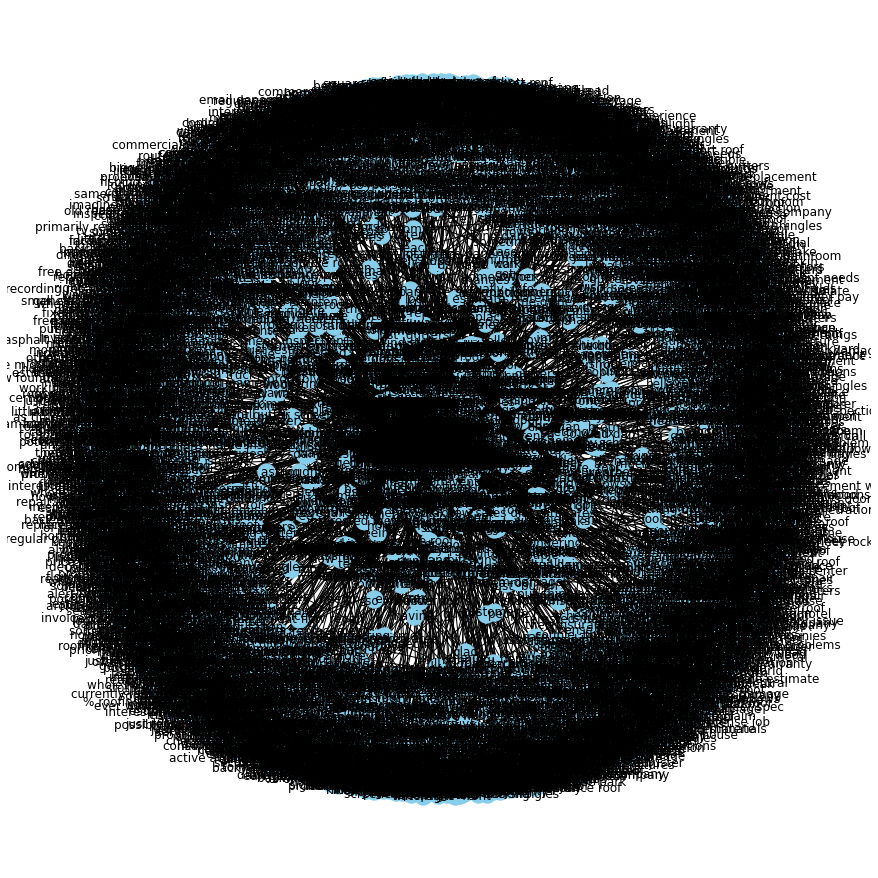

In [590]:
## flatten list
entity_pairs_flatten=[item for sublist in entity_pairs for item in sublist]
relationes_flatten=[item for sublist in relationes for item in sublist]

pd.Series(relationes).value_counts()
source=[i[0] for i in entity_pairs_flatten]
target=[i[1] for i in entity_pairs_flatten]
kg_df=pd.DataFrame({'source':source,'target':target,'edge':relationes_flatten})
#drop duplicate and remove if any space
kg_df=kg_df.drop_duplicates()
kg_df=kg_df[(kg_df['source']>'') & (kg_df['target']>'') & (kg_df['edge']>'')]


g=nx.from_pandas_edgelist(kg_df,"source","target",edge_attr=True,create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos=nx.spring_layout(g)
nx.draw(g,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos)
plt.show()


In [591]:
# kg_df[kg_df['edge']=="estimate"]
# kg_df.shape
# kg_df=kg_df.drop_duplicates()
# kg_df.shape


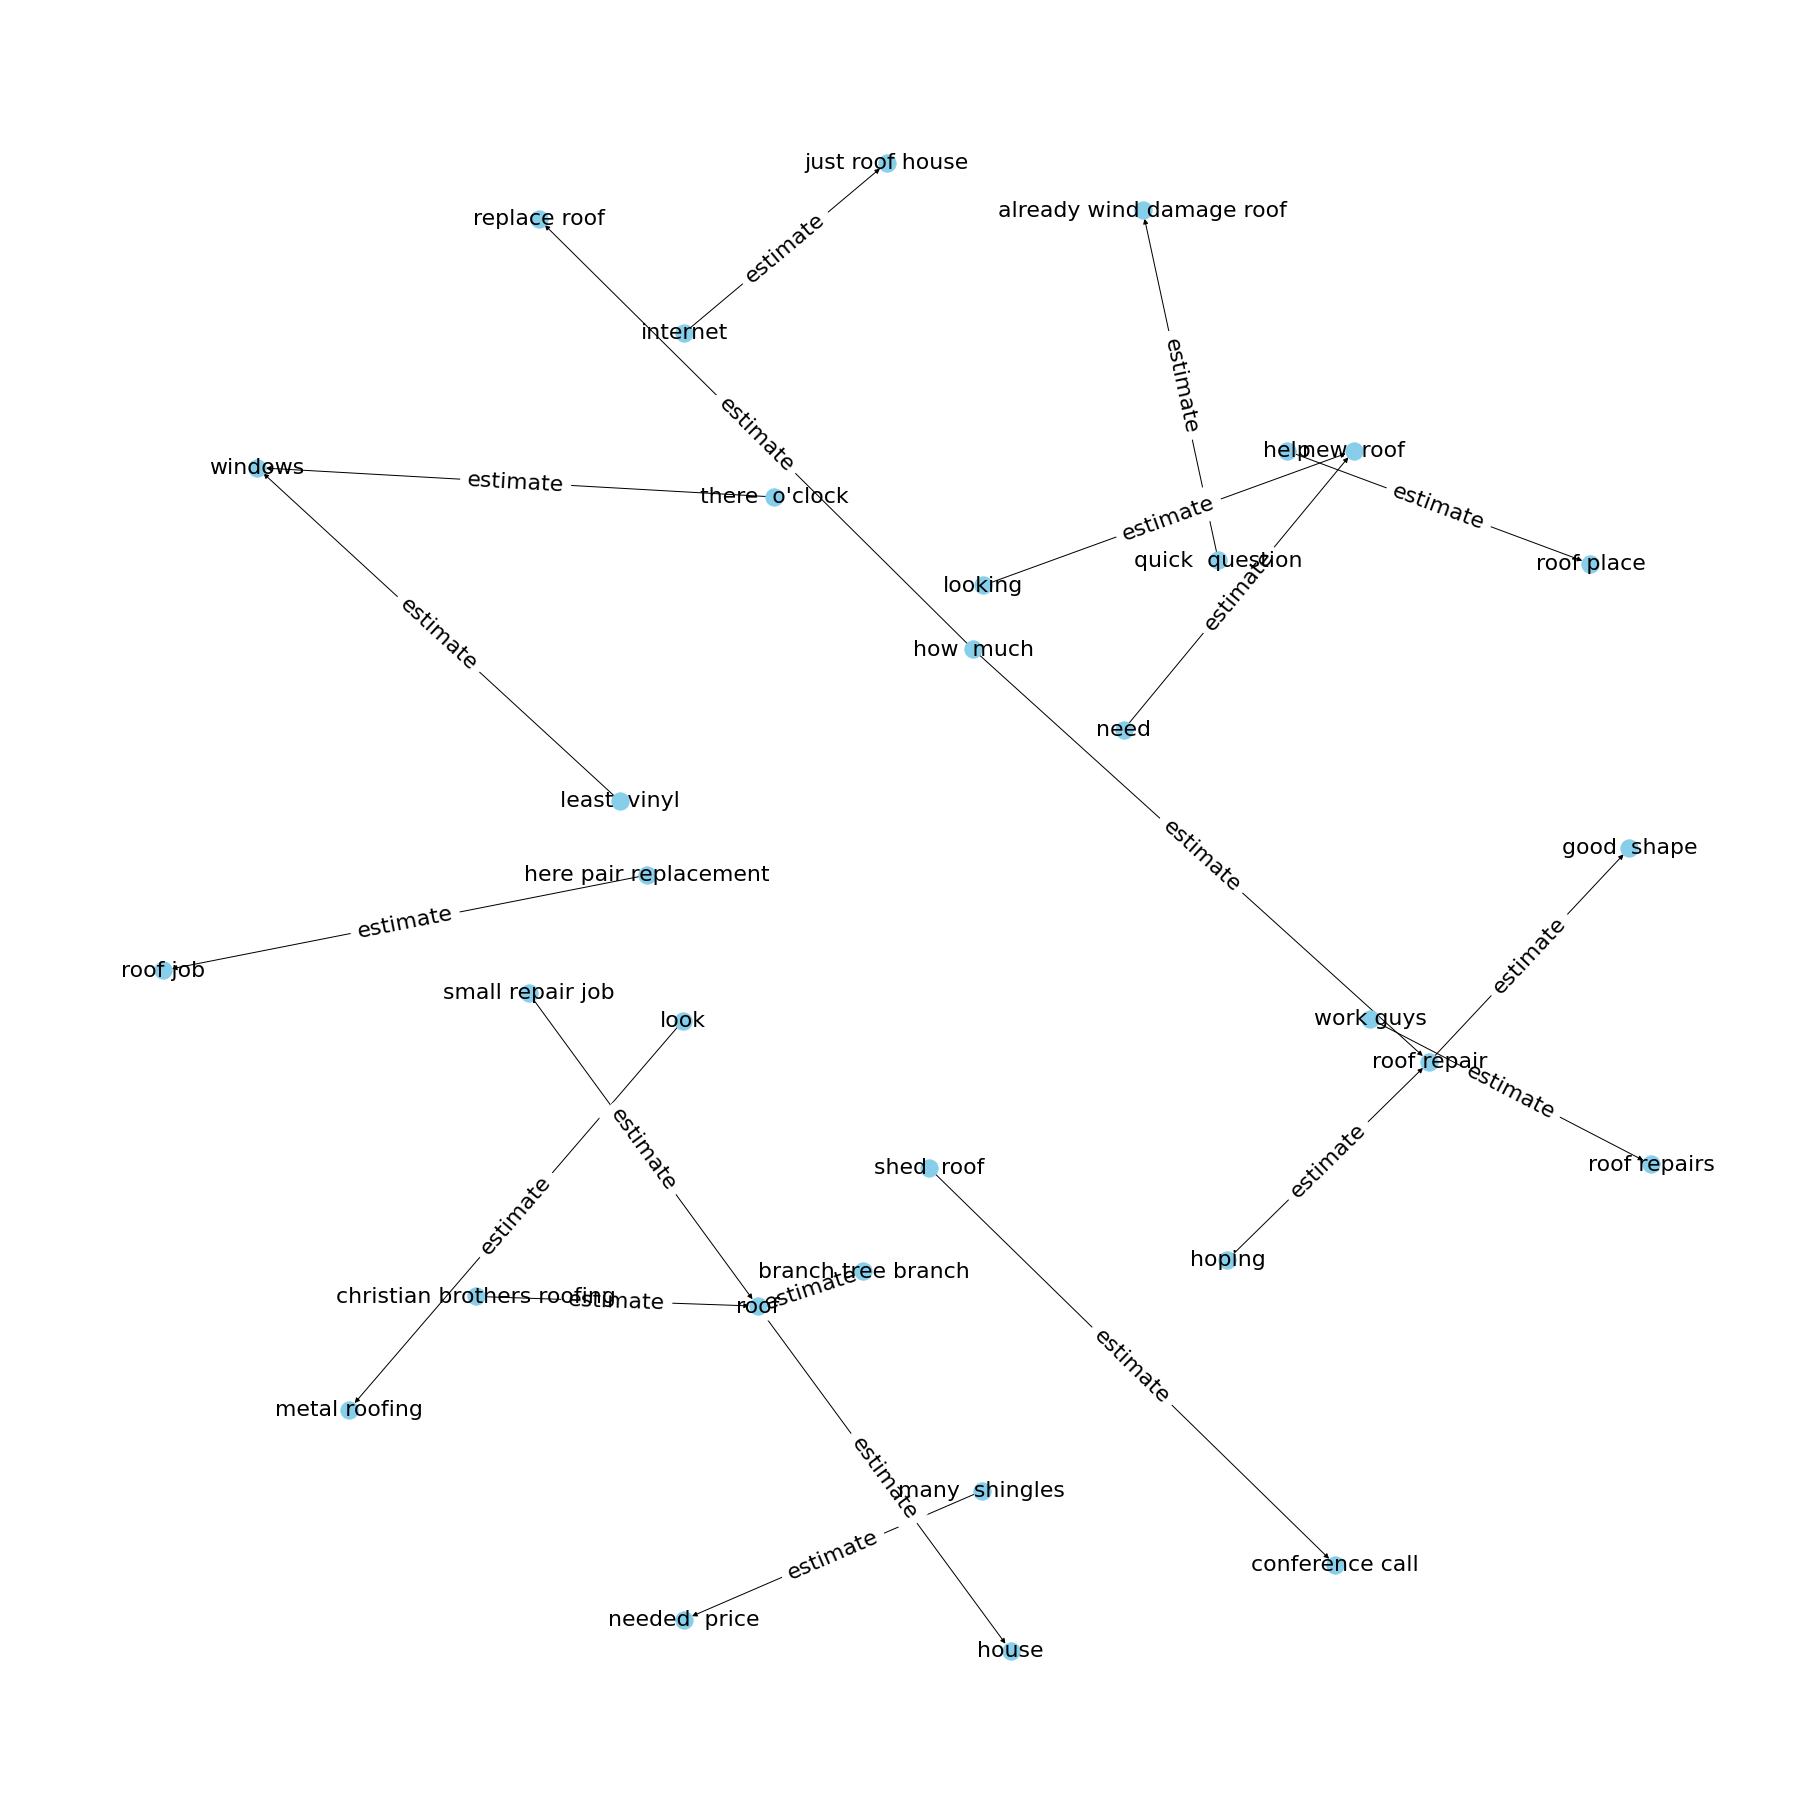

In [596]:
# g=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="estimate"][:20],"source","target",edge_attr=True,create_using=nx.MultiDiGraph())
g=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="estimate"][:20],"source","target",edge_attr='edge',create_using=nx.MultiDiGraph())
plt.figure(figsize=(25,25))
pos=nx.spring_layout(g,k=.5)
labels = {e: g.edges[e]['edge'] for e in g.edges}
labels={(k[0],k[1]):v for  k,v in labels.items()}
nx.draw(g,with_labels=True,node_color='skyblue',edge_cmap=plt.cm.Blues,pos=pos,font_size=22)
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels,font_size=22)
plt.show()




## Words relation plot

In [474]:
# # terms_bigram[1]
# textdata['nounverbtext'][1]
        
# vec1 = CountVectorizer(ngram_range=(2,2), 
#            max_features=2000).fit(textdata['nostoptext'])
# bag_of_words = vec1.transform(textdata['nostoptext']) 
# bag_of_words

# sum_words = bag_of_words.sum(axis=0) 
# words_freq = [(word, sum_words[0, idx]) for word, idx in     
#               vec1.vocabulary_.items()]
# words_freq =sorted(words_freq, key = lambda x: x[1], 
#             reverse=True)


In [493]:
# words_freq=[(w[0].split()[0],w[0].split()[1]) for w in words_freq]
# words_freq
# [l for l in textdata['nostoptext'][1].split()]

In [597]:
textdata['nostoptext']=textdata['nounverbtext'].apply(lambda x : ' '.join([item for item in x.split() if item not in stop]))
def cleanpuncdigit(sentence):
    cleaned=re.sub(r'[-|\|(|)|.|,|:|,|.|/|?|!|"|#]',r' ',sentence)
    cleaned=re.sub(r'[\d+]',r' ',cleaned)    
    cleaned=re.sub(r'[\'|’]',r'',cleaned)    #won't wont
    return cleaned
textdata['nostoptext']=textdata['nostoptext'].apply(cleanpuncdigit)



textdata['listtext']=textdata['nostoptext'].apply(lambda x: [l for l in x.split()])

from nltk import bigrams
alltext=textdata['listtext'].tolist()

terms_bigram = [list(bigrams(tweet)) for tweet in alltext]

# terms_bigram[0]

In [598]:
# terms_bigram[1]
# list(bigrams(textdata['nounverbtext'][1]))
# terms_bigram=words_freq
# bigrams = list(itertools.chain(*terms_bigram))

# bigrams
# bigram_counts

In [606]:
# d[0]
# G.edges
# nx.get_edge_attributes(G,'weight')


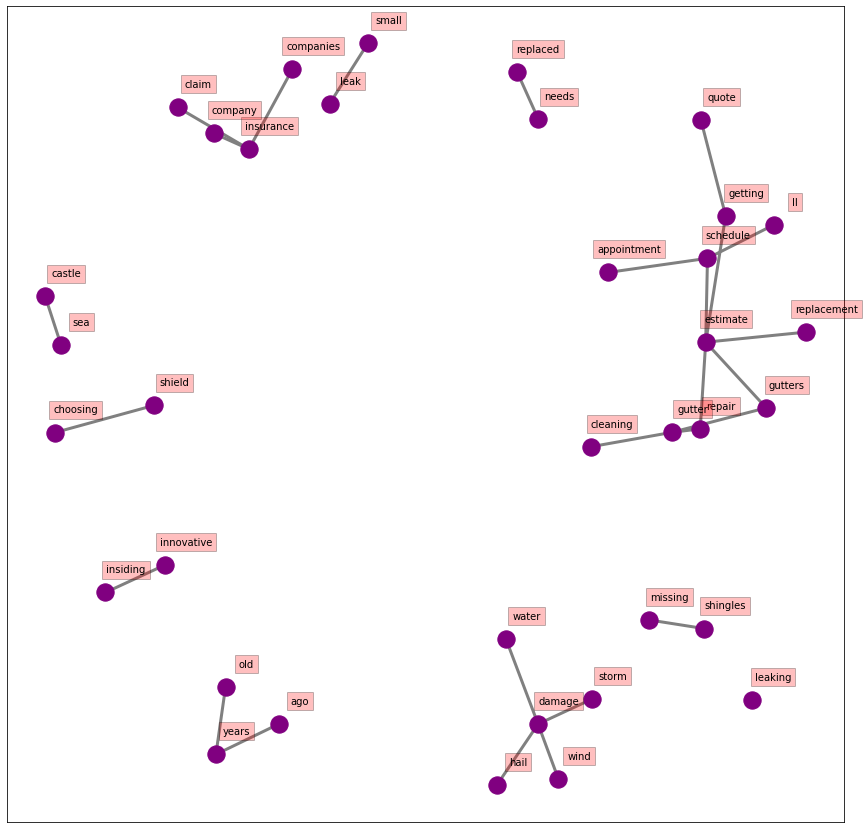

In [610]:
import itertools
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(30)
bigram_df = pd.DataFrame(bigram_counts.most_common(30),
                             columns=['bigram', 'count'])

d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# G.add_node("china", weight=100)

fig, ax = plt.subplots(figsize=(15, 15))

pos = nx.spring_layout(G, k=3.5)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 edge_attr=True,
                 with_labels = False,
                 ax=ax)

labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.05, value[1]+.05
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=10)
    
plt.show()

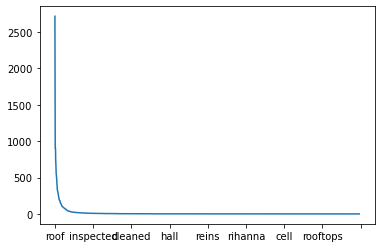

In [399]:
kg_df['edge'].value_counts().plot()

#### Show words most used in tweeter bigger size==more used

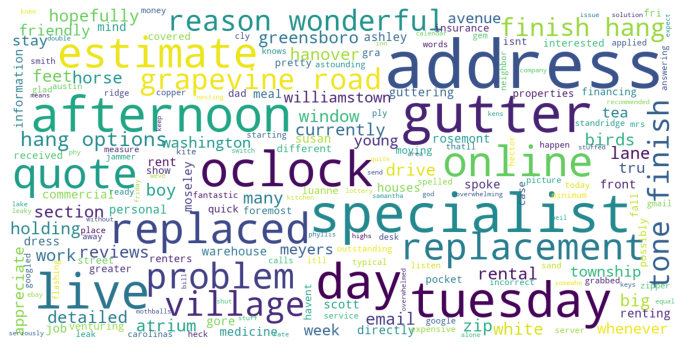

In [347]:
# create wordcloud
stopwords_set = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords_set,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(textdata['text'])

In [348]:
from collections import Counter
count_word=dict(Counter(" ".join(textdata['text']).split()).most_common(100))


In [349]:
# textdata['text']

In [350]:
# dict(count_word)
# textdata['text']=textdata['text'].apply(lambda x: ' '.join([w for w in x.split() if w in count_word.keys()]))

In [351]:
l=textdata['text'].str.lower().str.split().tolist()
print('No of unique words ',len(set([item for sublist in l for item in sublist])))


No of unique words  19096


## ML model
#### Here we are trying to get the most discussed topic in twitter. Say we want to identify 10 topic across the data available in twitter for the searchstrings. Once we get the topics we will show the top 10 important words of each topics. By displaying those top 10 words in each topic we can get some idea what people are talking about in twitter which might benifit the business.

## Create vector form of text data
#### We convert text to vector for applying machine learning model

In [352]:
def vectorize():

    # Initialise the count vectorizer
    count_vectorizer = CountVectorizer(min_df = 3, stop_words =[''])

    # Fit and transform the processed text
    count_data = count_vectorizer.fit_transform(textdata['text'])

    # Initialise the tfidf vectorizer 
    tfidf_vectorizer = TfidfVectorizer(min_df=3)

    # Fit and transform the processed text
    tfidf_data = tfidf_vectorizer.fit_transform(textdata['text'])
    
    return count_vectorizer, count_data, tfidf_vectorizer, tfidf_data

count_vectorizer, count_data, tfidf_vectorizer, tfidf_data = vectorize()

In [353]:
count_data.shape
# textdata['text'].shape

(5454, 7764)

### Hyperparameter for 3 models user input this is for tunning for ML model

In [357]:
search_params_lda = {'n_components': [5], 'doc_topic_prior':[.05,.03],'topic_word_prior':[.2,.3],'learning_decay': [.7]} # learning_decay between .5 and 1
#topic_word_prior/alpha with high value doc are made with more topic
#topic_word_prior with high value topic made with more words
search_params_nmf = {'n_components': [5], 'alpha':[.1], 'l1_ratio':[.5]} # with 10 n_component model perplexity 20000
#search_params_gensim={'num_topics':[10],'alpha':['asymmetric','auto',.1],'eta':[.1]}               
search_params_gensim={'num_topics':[5],'alpha':['auto'],'eta':[.1]}               


## Use LDA model for topic modelling

#### Use countvectorizer
#### Careful: Below steps will take time
#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

Best model's params:  {'doc_topic_prior': 0.05, 'learning_decay': 0.7, 'n_components': 5, 'topic_word_prior': 0.3}
Best log likelihood score:  -566454.0516994154
Model perplexity:  1850.5997064086182
Using best model below are topics and top n words


,Model,topic,word,weight
179,Model1(LDATF),3,monday,230.765785
120,Model1(LDATF),2,afternoon,180.384691
176,Model1(LDATF),3,contact,233.808139
238,Model1(LDATF),4,siding,156.530536
216,Model1(LDATF),4,located,221.208512
16,Model1(LDATF),0,road,461.162209
167,Model1(LDATF),3,story,333.534329
243,Model1(LDATF),4,worry,138.856682
206,Model1(LDATF),4,shield,294.249598
143,Model1(LDATF),2,exterior,118.821258


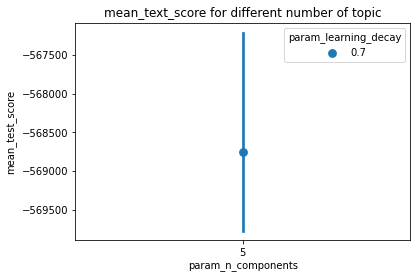

In [358]:
display_n_words=50
n_top_words=display_n_words
# do grid search and return best model for LDA
def modelcall(model_name,data,search_params):
    model = GridSearchCV(model_name, search_params)
    model.fit(data)   
    best_lda_model = model.best_estimator_
    print("Best model's params: ", model.best_params_)
    print("Best log likelihood score: ", model.best_score_)
    print("Model perplexity: ", best_lda_model.perplexity(data))
    return model

def model_score(model,count_vectorizer,count_data,n_top_words=50):

    # Topic - Keyword matrix
    best_lda_model = model.best_estimator_
    df_topic_keywords = pd.DataFrame(best_lda_model.components_)

    # assign column and index
    df_topic_keywords.columns = count_vectorizer.get_feature_names()
    topicnames = ['Topic_' + str(i) for i in range(best_lda_model.n_components)]
    df_topic_keywords.index = topicnames
    
    words = count_vectorizer.get_feature_names()
    print('Using best model below are topics and top n words')
    # Topic numberring below and in pyLDAvis may be different
    #for topic_idx, topic in enumerate(best_lda_model.components_):
        #print("\nTopic #%d:" % topic_idx)
        #print(" ".join([words[i]
        #                for i in topic.argsort()[:-n_top_words - 1:-1]]))    

    # check the head
    df_topic_keywords.iloc[:,:10]

    df_cv_results = pd.DataFrame(model.cv_results_)
    
    # plot cross validation result
    sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results).set_title('mean_text_score for different number of topic')
    
    # refered from https://shravan-kuchkula.github.io/topic-modeling/#appendix
    best_lda_model = model.best_estimator_
    try:
        panel = pyLDAvis.sklearn.prepare(best_lda_model, count_data, count_vectorizer, mds='tsne')
        vis=pyLDAvis.display(panel)
    except:
        print('error in pyldavis')
        vis=''
        panel=''
    return vis, best_lda_model, panel

#search_params_lda = {'n_components': [5], 'learning_decay': [.2]}  # with n_component=10 model_perplexity 2550. Lowest perplexity is best

model_name = LDA( n_jobs=-1)
n_top_words=display_n_words
df1=pd.DataFrame(columns=['Model','topic','word','weight'])    

count_vectorizer, count_data, tfidf_vectorizer, tfidf_data = vectorize()
final_model_lda_cv=modelcall(model_name,count_data,search_params_lda)
final_model_lda_cv_vis, best_lda_model,panel = model_score(final_model_lda_cv,count_vectorizer,count_data,n_top_words=50)

words = count_vectorizer.get_feature_names()

for topic_idx, topic in enumerate(best_lda_model.components_):
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            df1=df1.append({'Model':'Model1(LDATF)','topic':topic_idx, 'word':words[i],'weight':best_lda_model.components_[topic_idx][i]}, ignore_index=True)  # topic.argsort()[:-n_top_words - 1:-1][i]}, ignore_index=True )
      

df1.sample(10)
    
#final_model_lda_cv_vis

In [356]:
top_topic={}
top_n_words_topic=50
df1[df1['topic']==t].sort_values('weight',ascending=False)[['word','weight']][:top_n_words_topic]['word'].values

for t in range(df1['topic'].value_counts().shape[0]):
    top_topic[t]=' '.join(df1[df1['topic']==t].sort_values('weight',ascending=False)[['word','weight']][:top_n_words_topic]['word'].values.tolist())

top_topic

{0: 'address email week street work estimate tomorrow day road morning today area damage wednesday schedule google company story information storm monday old drive thursday years realty repair live martin appreciate pretty garage send south getting afternoon gutters big tuesday cellphone problem office friday ashley gmail quote minute shingles allison second',
 1: 'gutters gutter address repair send estimate email day shingles information work area front window quote replace problem service replaced today years water hang appreciate repairs needs stuff finish price road replacement old big tomorrow getting options job long spouts feet damage castle morning google live inspection foot company door tone',
 2: 'quality service construction options tone shield hang office improvement estimate needs family finished located customer west representative contact project hours area commercial partys cost offer assurance improvements siding purposes work company pound residential details necessa

In [ ]:
#estimate
#gutter service
#commercial customer
#appointment schedule
#insurance coverage
#------ 
# 'address','information'


In [333]:


best_lda_model.transform(count_data)

# Create Document — Topic Matrix
lda_output = best_lda_model.transform(count_data)
# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(count_data.shape[0])]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic


In [334]:
df_document_topic.shape
df_document_topic_new=pd.concat([df_document_topic.reset_index(),textdata[['text']].reset_index()],axis=1)
df_document_topic_new.shape
# count_data.shape
# textdata['text'].shape

(5454, 9)

In [335]:
len(df1['word'].values.tolist())

250

In [339]:
df_document_topic_new['imp_text']=df_document_topic_new['text'].apply(lambda x : set([l for l in x.split() if l in df1['word'].values.tolist()]))

df_document_topic_new.sample(10)

,index,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,index,text,imp_text
3002,Doc3002,0.00,0.49,0.39,0.00,0.11,1,3029,morning company check gutter needs replaced needs replaced gutters pretty address street replaced needs replaced company free estimate appointment email,"[morning, company, check, gutter, needs, replaced, needs, replaced, gutters, pretty, address, street, replaced, needs, replaced, company, free, estimate, appointment, email]"
1962,Doc1962,0.01,0.01,0.01,0.96,0.01,3,1986,leak repair afternoon email address email gmail afternoon appreciate day,"[leak, repair, afternoon, email, address, email, gmail, afternoon, appreciate, day]"
2641,Doc2641,0.01,0.01,0.01,0.98,0.01,3,2667,construction quote afternoon away line information quote problem email address yahoo yahoo street address road road zip google problem,"[construction, quote, afternoon, away, line, information, quote, problem, email, address, yahoo, yahoo, street, address, road, road, zip, google, problem]"
3429,Doc3429,0.02,0.02,0.02,0.91,0.02,3,3458,estimate address street street,"[estimate, address, street, street]"
4424,Doc4424,0.00,0.00,0.00,0.98,0.00,3,4459,construction construction repair stuff leaking area definitely address road away line today definitely today second email address email address email gmail gmail gmail information day,"[construction, construction, repair, stuff, leaking, area, definitely, address, road, away, line, today, definitely, today, second, email, address, email, address, email, gmail, gmail, gmail, information, day]"
1432,Doc1432,0.01,0.01,0.01,0.35,0.62,4,1456,day hang options cost inspection inspection estimate shingles,"[day, hang, options, cost, inspection, inspection, estimate, shingles]"
201,Doc201,0.01,0.01,0.01,0.96,0.01,3,201,estimate today google google service address zip repair information day,"[estimate, today, google, google, service, address, zip, repair, information, day]"
1279,Doc1279,0.02,0.02,0.02,0.02,0.93,4,1303,quality schedule appointment estimates quality,"[quality, schedule, appointment, estimates, quality]"
1844,Doc1844,0.05,0.79,0.00,0.16,0.00,1,1868,problem leak repair repairs work repairs line line window window leak front front work address meet street hope story front leaking line getting window front old year front big company problem metal line leak metal problem shingles top water top shingle leaking line area year old leaking front cost front front looks looks estimate,"[problem, leak, repair, repairs, work, repairs, line, line, window, window, leak, front, front, work, address, meet, street, hope, story, front, leaking, line, getting, window, front, old, year, front, big, company, problem, metal, line, leak, metal, problem, shingles, top, water, top, shingle, leaking, line, area, year, old, leaking, front, cost, front, front, looks, looks, estimate]"
3262,Doc3262,0.10,0.44,0.00,0.46,0.00,3,3290,afternoon today inspection big storm water check repair old inspection storm water check water problem check located second repair repair information address send week care email address gmail address second google google old year story gutter water water gutter else check water check gutters water shingle metal shingles schedule looks week monday day work day appointment far monday appreciate care,"[afternoon, today, inspection, big, storm, water, check, repair, old, inspection, storm, water, check, water, problem, check, located, second, repair, repair, information, address, send, week, care, email, address, gmail, address, second, google, google, old, year, story, gutter, water, water, gutter, else, check, water, check, gutters, water, shingle, metal, shingles, schedule, looks, week, monday, day, work, day, appointment, far, monday, appreciate, care]"


In [242]:
print(textdata.shape)

top_n_words_topic=20

# df1[df1['topic']==t].sort_values('weight',ascending=False)[['word','weight']][:top_n_words_topic]
df1[(df1['topic']==0) & (df1['word']=='roofing')]['weight'][0]
# df1.head(2)

(5454, 12)


659.0399600726209

In [203]:
#take top 20 words for each topic and form dict
top_n_words_topic=20
ll=list(range(df1['topic'].value_counts().shape[0]))
topic_word={}
print(topic_word)
for t in range(df1['topic'].value_counts().shape[0]):
#     print(df1[df1['topic']==4].sort_values('weight',ascending=False))
    for w in df1[df1['topic']==t].sort_values('weight',ascending=False)['word'][:top_n_words_topic].values:
        topic_word[w]=df1[(df1['topic']==t) & (df1['word']==w)]['weight'][0]
        print(topic_word)
    break
    
# ,

KeyError: "None of ['word'] are in the columns"

In [25]:
## Store result in table
#best_lda_model
df1.shape   

(7200, 5)

1it [00:03,  3.72s/it]


In [144]:
textdata.shape

(5454, 14)

#### Use tfidf
#### Careful: Below steps will take time
#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

Best model's params:  {'doc_topic_prior': 0.1, 'learning_decay': 0.5, 'n_components': 5, 'topic_word_prior': 0.1}
Best log likelihood score:  -74202.91158765827
Model perplexity:  7625.474833082581
Using best model below are topics and top n words


,Model,topic,word,weight
0,Model2(LDATFIDF),0,tone,40.945541
1,Model2(LDATFIDF),0,hang,33.522390
2,Model2(LDATFIDF),0,options,32.729570
3,Model2(LDATFIDF),0,finished,22.939151
4,Model2(LDATFIDF),0,finish,20.850238
5,Model2(LDATFIDF),0,voice,16.267408
6,Model2(LDATFIDF),0,jenkins,11.674295
7,Model2(LDATFIDF),0,messaging,11.267640
8,Model2(LDATFIDF),0,premier,11.151075
9,Model2(LDATFIDF),0,system,9.615095


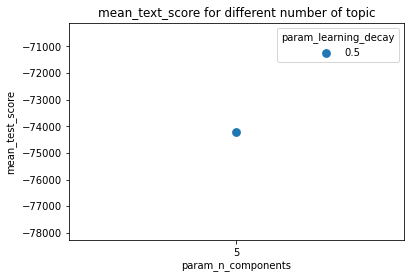

In [271]:
model_name = LDA(n_jobs=-1)
final_model_lda_tf=modelcall(model_name,tfidf_data,search_params_lda)
final_model_lda_tf_vis, best_lda_model_tf, panel=model_score(final_model_lda_tf,tfidf_vectorizer,tfidf_data)
final_model_lda_tf_vis

words = tfidf_vectorizer.get_feature_names()    
df2=pd.DataFrame(columns=['Model','topic','word','weight'])    
for topic_idx, topic in enumerate(best_lda_model_tf.components_):
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            df2=df2.append({'Model':'Model2(LDATFIDF)','topic':topic_idx, 'word':words[i],'weight':best_lda_model_tf.components_[topic_idx][i]}, ignore_index=True)  # topic.argsort()[:-n_top_words - 1:-1][i]}, ignore_index=True )
      

df2.head(10)   


In [ ]:
top_topic={}
top_n_words_topic=50
df2[df2['topic']==t].sort_values('weight',ascending=False)[['word','weight']][:top_n_words_topic]['word'].values

for t in range(df2['topic'].value_counts().shape[0]):
    top_topic[t]=' '.join(df2[df2['topic']==t].sort_values('weight',ascending=False)[['word','weight']][:top_n_words_topic]['word'].values.tolist())

top_topic


## Use NMF(Non Matrix factorization) model for topic modelling

#### Use countvectorizer
#### Careful: Below steps will take time

In [94]:


# Grid search
def gridsearch_nmf(search_params,count_data,count_vectorizer,n_top_words):
    error=1000000

    for i in search_params['n_components']:
        for j in search_params['alpha']:
            for k in search_params['l1_ratio']:
                #print('for ',i,j,k)
                model_name=NMF(n_components=i,alpha=j,l1_ratio=k)
                model_name.fit(count_data)
                #print(model_name.reconstruction_err_)
                if model_name.reconstruction_err_<error:
                    error=model_name.reconstruction_err_
                    #print('Better model',model_name.reconstruction_err_,i,j,k)
                    final_model=model_name
    words = count_vectorizer.get_feature_names()
    print('From grid search best model reconstraction error',final_model.reconstruction_err_,' with number of topic ',final_model.n_components)
    print('For best model topics and top n words with their weights')
    for topic_idx, topic in enumerate(final_model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]+" "+str(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))   
        
    return final_model
    
        
#search_params = {'n_components': [5], 'alpha':[0.0], 'l1_ratio':[0.0]} # with 10 n_component model perplexity 20000
final_model_nmf_cv=gridsearch_nmf(search_params=search_params_nmf,count_data=count_data,count_vectorizer=count_vectorizer,n_top_words=display_n_words)

words = count_vectorizer.get_feature_names()    
df3=pd.DataFrame(columns=['Model','topic','word','weight'])    
for topic_idx, topic in enumerate(final_model_nmf_cv.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]+" "+str(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))  
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            df3=df3.append({'Model':'Model3(NMFTF)','topic':topic_idx, 'word':words[i],'weight':final_model_nmf_cv.components_[topic_idx][i]}, ignore_index=True)  # topic.argsort()[:-n_top_words - 1:-1][i]}, ignore_index=True )

From grid search best model reconstraction error 403.74200503056795  with number of topic  10
For best model topics and top n words with their weights

Topic #0:
protected 6.7583811166258405 youre 3.8369815733007524 insurance 3.5594413586219145 home 3.509480191294696 head 3.492588605584237 risks 0.05608739402488477 protects 0.027814489319414194 wealth 0.02774588996452848 lifes 0.027690579037260264 natures 0.027074418743317123 personal 0.026968071533547657 homeowners 0.025264295031484765 making 0.02370333401065702 sure 0.022044298765773067 call 0.021854947475882975

Topic #1:
amp 9.054156386749467 blow 0.6965153799756062 covered 0.6773348218470521 china 0.6554395261528984 fed 0.653232038563046 massive 0.6447321890956123 harvard 0.636424390203013 medical 0.6266207157109955 insiders 0.6219825238431388 killed 0.620421386595211 scandal 0.6182592363022906 exclusive 0.6101227684371568 obama 0.6077703516039211 justice 0.6066115137356505 dept 0.6006681712076904

Topic #2:
like 10.08578041344746

In [95]:
df3.head(20)    


,Model,topic,word,weight
0,Model3(NMFTF),0,protected,6.758381
1,Model3(NMFTF),0,youre,3.836982
2,Model3(NMFTF),0,insurance,3.559441
3,Model3(NMFTF),0,home,3.509480
4,Model3(NMFTF),0,head,3.492589
5,Model3(NMFTF),0,risks,0.056087
6,Model3(NMFTF),0,protects,0.027814
7,Model3(NMFTF),0,wealth,0.027746
8,Model3(NMFTF),0,lifes,0.027691
9,Model3(NMFTF),0,natures,0.027074


#### tfidf vectorizer
#### Careful: Below steps will take time

In [96]:

final_model_nmf_tf=gridsearch_nmf(search_params=search_params_nmf,count_data=tfidf_data,count_vectorizer=tfidf_vectorizer,n_top_words=display_n_words)

words = tfidf_vectorizer.get_feature_names()    
df4=pd.DataFrame(columns=['Model','topic','word','weight'])    
for topic_idx, topic in enumerate(final_model_nmf_tf.components_):
        #print("\nTopic #%d:" % topic_idx)
        #print(" ".join([words[i]+" "+str(topic[i])
        #                for i in topic.argsort()[:-n_top_words - 1:-1]]))  
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            df4=df4.append({'Model':'Model4(NMFTFIDF)','topic':topic_idx, 'word':words[i],'weight':final_model_nmf_tf.components_[topic_idx][i]}, ignore_index=True)  # topic.argsort()[:-n_top_words - 1:-1][i]}, ignore_index=True )
df4.head(20)

From grid search best model reconstraction error 154.4110350035796  with number of topic  10
For best model topics and top n words with their weights

Topic #0:
protected 5.029894807279501 insurance 2.4689678147686873 youre 2.4024315769596662 home 2.1164410223444907 head 1.907221025018966 risks 0.016228905527973528 homeowners 0.010386059968020863 car 0.007344859802772867 stay 0.00651193113392713 many 0.005709286637876512 protects 0.005601873762321381 rates 0.00555600225809029 well 0.004845963798675921 wealth 0.004658660432386152 lives 0.004603757435210228

Topic #1:
anxiety 6.870263763282407 today 0.8413726219609515 right 0.4309883706658382 thru 0.3981901712524765 fucking 0.27614258295847666 lately 0.17260379801016204 went 0.15569996652595888 cant 0.15467565759039045 goes 0.15327782844299295 levels 0.13899515222154862 hate 0.12884029612908923 days 0.11971873453461623 level 0.118710301187989 morning 0.1041561121148961 quarantine 0.09976803036631281

Topic #2:
mouth 5.986735808771361 ton

,Model,topic,word,weight
0,Model4(NMFTFIDF),0,protected,5.029895
1,Model4(NMFTFIDF),0,insurance,2.468968
2,Model4(NMFTFIDF),0,youre,2.402432
3,Model4(NMFTFIDF),0,home,2.116441
4,Model4(NMFTFIDF),0,head,1.907221
5,Model4(NMFTFIDF),0,risks,0.016229
6,Model4(NMFTFIDF),0,homeowners,0.010386
7,Model4(NMFTFIDF),0,car,0.007345
8,Model4(NMFTFIDF),0,stay,0.006512
9,Model4(NMFTFIDF),0,many,0.005709



    
## Use gensim model    
#### Create text corpus

In [97]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(textdata['text']))

print(data_words[:1])

id2word = corpora.Dictionary(data_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# View
print(corpus[:1])

[['pryor', 'damage', 'pryor', 'movie', 'theatre']]
[[(0, 1), (1, 1), (2, 2), (3, 1)]]


#### Grid search
#### Careful: Below steps will take time

In [98]:
def gensin_gs(search_params,corpus,data_words):
    perplixity=100000
    coherance=0
    for i in search_params['num_topics']:
        for j in search_params['alpha']:
                for k in search_params['eta']:
                        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=j,
                                           eta=k,                         
                                           per_word_topics=True)
                        doc_lda = lda_model[corpus]
                        
                        # Compute Coherence Score
                        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
                        # compute perplexist
                        ps=lda_model.log_perplexity(corpus)
                        with np.errstate(invalid='ignore'):
                            coherence_lda = coherence_model_lda.get_coherence()
                        print('/n/nFor topics, alpha, eta values : ',i,j,k)    
                        print('Perplexity: ', ps,'\nCoherence Score: ', coherence_lda)  # a measure of how good the model is. lower the better.

                        if (coherence_lda>coherance):  # & (ps <perplixity):
                            final_model=lda_model

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

    return final_model, vis    

final_model_gensim,final_model_gensim_vis=gensin_gs(search_params_gensim,corpus,data_words)
final_model_gensim_vis


/n/nFor topics, alpha, eta values :  10 auto 0.1
Perplexity:  -10.210537315676165 
Coherence Score:  0.37821535479470547


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.420739 -0.003143       1        1  16.912891
2     -0.043552  0.385627       2        1  12.612205
5     -0.047509 -0.176303       3        1  12.369504
6     -0.047616 -0.040993       4        1  10.845532
0     -0.047163 -0.031354       5        1   9.374930
7     -0.048597 -0.031691       6        1   8.977416
9     -0.047627 -0.030169       7        1   8.839164
1     -0.047377 -0.027931       8        1   8.452556
3     -0.046885 -0.022033       9        1   6.089129
4     -0.044414 -0.022010      10        1   5.526668, topic_info=          Term         Freq        Total Category  logprob  loglift
114       home  1213.000000  1213.000000  Default  30.0000  30.0000
315       head  1334.000000  1334.000000  Default  29.0000  29.0000
260        one  1394.000000  1394.000000  Default  28.0000  28.0000
77         new  1322.000000  1322.000000  Default  27.0000  27.0000
5         like  1482.000000  1482.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
13706   newsom    69.146660    70.108658  Topic10  -5.0033   2.8818
3032   blessed    68.507309    69.469543  Topic10  -5.0126   2.8816
1492      post    67.835831    68.797943  Topic10  -5.0225   2.8815
2469   shelley    97.960594   109.651283  Topic10  -4.6550   2.7828
1665       edt    83.031799    90.839455  Topic10  -4.8203   2.8057

[332 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
566       6  0.991639       able
196       2  0.995479    account
1366      8  0.994041     across
2079      1  0.994485        air
1512      6  0.989393     almost
...     ...       ...        ...
900       8  0.993830       year
535       8  0.997514      years
218       1  0.994481        yes
1883     10  0.988292  yesterday
324       4  0.998706      youre

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 6, 7, 1, 8, 10, 2, 4, 5])

In [99]:
x=final_model_gensim.show_topics(num_topics=10, num_words=display_n_words,formatted=False)
topics_words = [(tp[0], [(wd[0],wd[1]) for wd in tp[1]]) for tp in x]

df5=pd.DataFrame(columns=['Model','topic','word','weight'])    

#Below Code Prints Topics and Words
for topic,words in topics_words:
    for word in words:
            df5=df5.append({'Model':'Model5(GENSIM)','topic':topic, 'word':word[0],'weight':word[1]}, ignore_index=True)  # topic.argsort()[:-n_top_words - 1:-1][i]}, ignore_index=True )
            #print(str(topic)+ "::"+ str(word[0])+ "::"+ str(word[1]))
df5.head(20)    

,Model,topic,word,weight
0,Model5(GENSIM),0,time,0.050440
1,Model5(GENSIM),0,could,0.029498
2,Model5(GENSIM),0,right,0.025223
3,Model5(GENSIM),0,getting,0.019283
4,Model5(GENSIM),0,every,0.016203
5,Model5(GENSIM),0,first,0.013361
6,Model5(GENSIM),0,didnt,0.013179
7,Model5(GENSIM),0,looking,0.012733
8,Model5(GENSIM),0,little,0.012525
9,Model5(GENSIM),0,always,0.012451


In [108]:
df2.head(5)

,Model,topic,word,weight
0,Model2(LDATFIDF),0,fire,58.952553
1,Model2(LDATFIDF),0,raise,36.356501
2,Model2(LDATFIDF),0,one,31.562452
3,Model2(LDATFIDF),0,koreans,27.072627
4,Model2(LDATFIDF),0,tops,24.914027


## Save all model output

In [75]:
df1.to_gbq(destination_table='twitter_analysis.topics',project_id = 'gaf-np-ds',if_exists = 'replace')  #'replace')
#df2.to_gbq(destination_table='twitter_analysis.topics',project_id = 'gaf-np-ds',if_exists = 'append')  #'replace')
#df3.to_gbq(destination_table='twitter_analysis.topics',project_id = 'gaf-np-ds',if_exists = 'append')  #'replace')
#df4.to_gbq(destination_table='twitter_analysis.topics',project_id = 'gaf-np-ds',if_exists = 'append')  #'replace')
#df5.to_gbq(destination_table='twitter_analysis.topics',project_id = 'gaf-np-ds',if_exists = 'append')  #'replace')

1it [00:03,  3.21s/it]


#### Below interactive plot will show the importants words(right side) for a topic(left side circle) if cursor is placed on a topic.

In [44]:
#final_model_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100,
#                                           update_every=1,chunksize=100,passes=10,alpha='auto',eta=.5, per_word_topics=True)
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(final_model_gensim, corpus, id2word)
#vis


## Conclusions
#### In this analysis we tried to identify 10 most important topics discussed in twitter from 16-04-2020 to 20-04-2020 by looking into twitter text in USA location, And for each topic 15 most important words are shown above. The intention is to help business by showing this analysis. 
#### This script can be used for identifying topics from any keyword text and any date and any location by changing parameters.
#### As we are aware currently the whole world is talking about COVID-19, so its bit difficult to get other sensible topic related to roofing excluding COVID-19 related texts, which leave us only few tweets.
#### We can also use some other Machile learning algorithm to help business.
#### Depanding on good selection of text we are looking in twitter the performance of model will improve.
#### This analysis can show better result with better infracture of CPU/cloud and using more data points. This analysis is based on 30k data points and model building is not optimize, this is just to display initial result
